<a href="https://colab.research.google.com/github/Rohan2390/AVENDI_PYTORCH/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DATA PREPARATION ###

In [1]:
from PIL import Image
path2content = "/content/drive/MyDrive/NEURAL_STYLE_TRANSFER/content4.jpg"
path2style = "/content/drive/MyDrive/NEURAL_STYLE_TRANSFER/style3.jpg"
content4_img = Image.open(path2content)
style3_img = Image.open(path2style)

In [2]:
content4_img

In [ ]:
style3_img

In [29]:
import torchvision.transforms as transforms
h, w = 400, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)
transformer = transforms.Compose([transforms.Resize((h,w)),
                                  transforms.ToTensor(),transforms.Normalize(mean_rgb, std_rgb)])

### Transform PIL image to Tensors ###

In [4]:
content_tensor = transformer(content4_img)
print(content_tensor.shape, content_tensor.requires_grad)
style_tensor = transformer(style3_img)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 400, 384]) False
torch.Size([3, 400, 384]) False


### Transform back tensors to PIL images

In [5]:
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c*=torch.tensor(std_rgb).view(3,1,1)
    img_tensor_c+=torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c=img_tensor_c.clamp(0,1)
    img_pil=to_pil_image(img_tensor_c)
    return img_pil

Text(0.5, 1.0, 'content image')

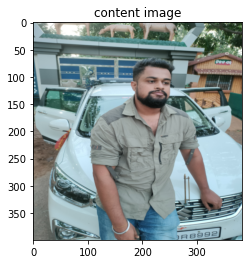

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image
plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image")

Text(0.5, 1.0, 'style image')

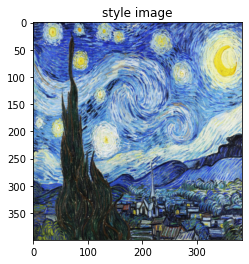

In [7]:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image")

### **pretrained model**

In [8]:
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
model_vgg =models.vgg19(pretrained=True).features.to(device).eval()
print(model_vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
for param in model_vgg.parameters():
    param.requires_grad_(False) 

**LOSS FUNCTIONS**

In [10]:
def get_features(x,model , layers):
    features = {}
    for name , layer in enumerate (model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [11]:
def gram_matrix(x):
    n ,c , h ,w = x.size()
    x = x.view(n*c , h*w)
    gram = torch.mm(x , x.t())
    return gram

In [12]:
#CONTENT LOSS
import torch.nn.functional as F

In [13]:
def get_content_loss(pred_features,target_features,layer):
    target=target_features[layer]
    pred=pred_features[layer]
    loss=F.mse_loss(pred,target)
    return loss

In [14]:
def get_style_loss(pred_features , target_features,style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea=pred_features[layer]
        pred_gram=gram_matrix(pred_fea)
        n,c,h,w=pred_fea.shape
        target_gram=gram_matrix(target_features[layer])
        layer_loss=style_layers_dict[layer] * F.mse_loss(pred_gram,target_gram)
        loss+=layer_loss/(n*c*h*w)
    return loss


In [15]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

In [16]:
con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

In [17]:
content_features = get_features(con_tensor, model_vgg,feature_layers)
style_features = get_features(sty_tensor, model_vgg,feature_layers)

In [18]:
for key in content_features.keys():   
     print(content_features[key].shape)

torch.Size([1, 64, 400, 384])
torch.Size([1, 128, 200, 192])
torch.Size([1, 256, 100, 96])
torch.Size([1, 512, 50, 48])
torch.Size([1, 512, 50, 48])
torch.Size([1, 512, 25, 24])


In [19]:
input_tensor = con_tensor.clone().requires_grad_(True)

In [37]:
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.001)

In [45]:
num_epochs = 501
content_weight = 0.1
style_weight = 10
content_layer = "conv5_1"
style_layers_dict = { 'conv1_1': 0.75,
                     'conv2_1': 0.5,
                     'conv3_1': 0.25,
                     'conv4_1': 0.25,
                     'conv5_1': 0.25}

In [46]:
for epoch in range(num_epochs+1):    
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg,feature_layers)
    content_loss = get_content_loss (input_features,content_features, content_layer)
    style_loss = get_style_loss(input_features, style_features,style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight *style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
         print('epoch {}, content loss: {:.2}, style loss{:.2}'.format(epoch,content_loss,style_loss))

epoch 0, content loss: 2.3, style loss0.59
epoch 100, content loss: 4.6, style loss0.35
epoch 200, content loss: 4.8, style loss0.28
epoch 300, content loss: 4.8, style loss0.24
epoch 400, content loss: 4.9, style loss0.21
epoch 500, content loss: 4.9, style loss0.19


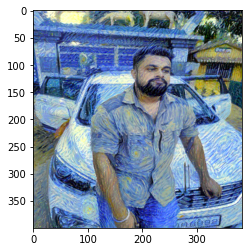

In [47]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()));

In [41]:
input_tensor[0]

tensor([[[ 5.6953e-01,  5.2679e-01,  3.9802e-01,  ..., -1.4925e+00,
          -1.8080e+00, -2.1204e+00],
         [ 2.0379e-01,  5.1731e-01,  2.6099e-01,  ..., -8.4205e-01,
          -1.4715e+00, -1.8477e+00],
         [ 2.9721e-01,  6.1858e-01,  8.5490e-02,  ..., -2.1023e-01,
          -1.6703e+00, -1.8830e+00],
         ...,
         [-4.0750e-01, -3.6962e-01, -3.0800e-01,  ...,  1.9598e-01,
           1.2328e-01, -8.4749e-02],
         [-4.8322e-01, -2.9920e-01, -1.1272e-03,  ...,  2.8934e-01,
           2.9665e-01, -1.8314e-02],
         [-6.0082e-01, -2.8894e-01,  4.7191e-02,  ..., -3.7644e-02,
           4.0626e-01, -7.9364e-02]],

        [[ 8.0400e-01,  1.2970e+00,  5.5185e-01,  ..., -8.6442e-01,
          -1.1326e+00, -1.2216e+00],
         [ 7.7897e-01,  1.3535e+00,  1.1791e+00,  ..., -2.3623e-01,
          -4.1453e-01, -1.1311e+00],
         [ 9.1637e-01,  1.1354e+00,  1.0955e+00,  ..., -3.9882e-01,
          -8.9839e-01, -1.2398e+00],
         ...,
         [ 1.4246e-01, -1